<a href="https://colab.research.google.com/github/HanbumKo/DRL-course/blob/main/3_A3C/3_1_A3C_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A3C

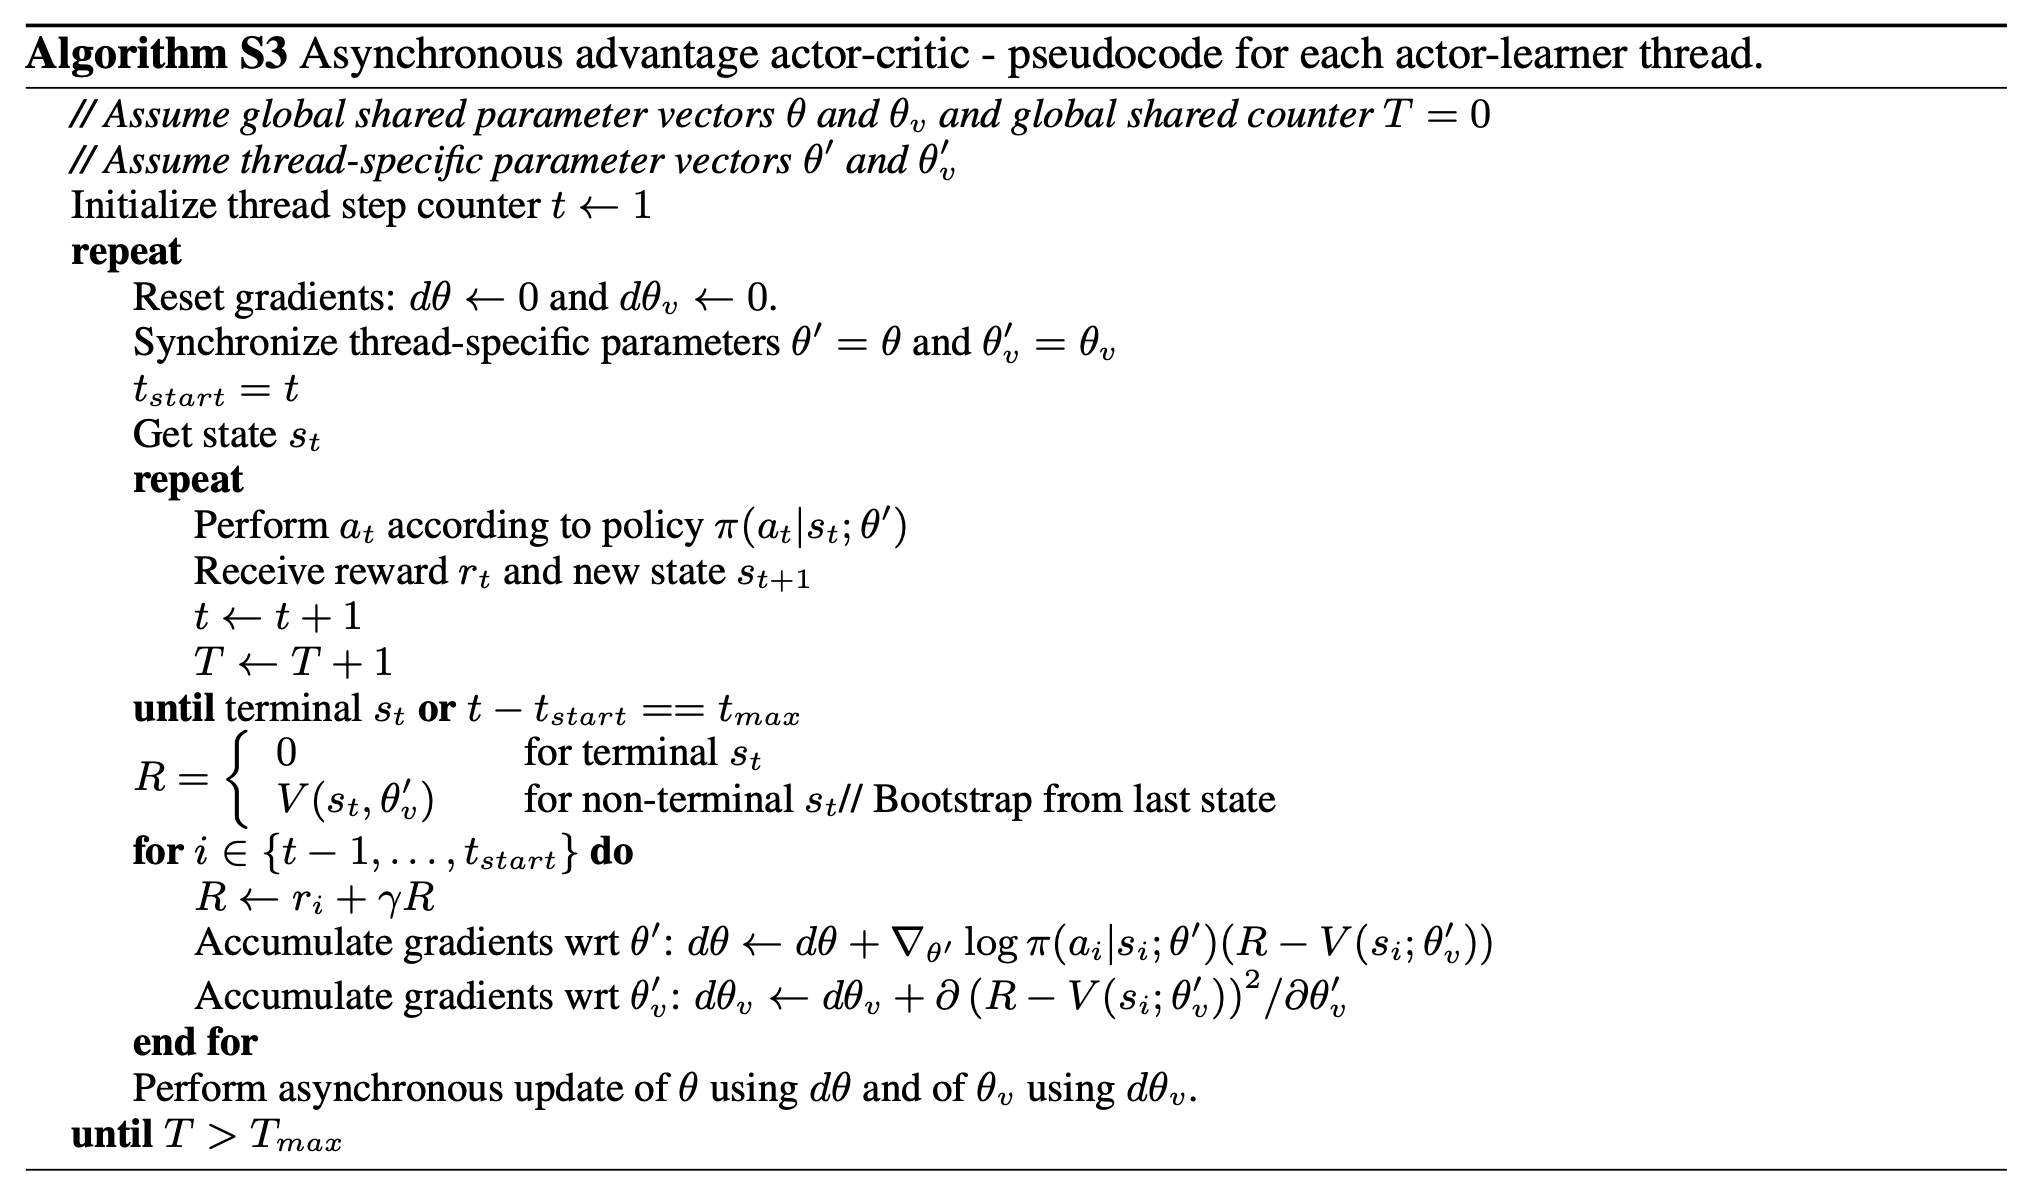

이번 노트북에서는 Ray를 이용해서 A3C를 구현해보도록 하겠습니다.

!pip를 통해 먼저 ray를 설치해줍니다.

In [ ]:
!pip install ray

In [2]:
import ray
import gym
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from gym import spaces

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Policy & value function

CartPole 환경의 policy 와 value function을 나타내는 뉴럴넷 모델입니다.

policy network에서는

get_action_logprob()를 통해 action을 샘플링하고 그 action에 대한 log probability도 같이 반환하여줍니다.

value network에서는 get_value()를 통해 value값을 얻을 수 있습니다.

두 network 공통으로

get_weights()를 통해 weight값(parameter값)을 얻을 수 있고,

get_grad()를 통해 파라미터들의 gradient값을 얻을 수 있고,

set_grad()를 통해 파라미터들에게 gradient를 설정하여 줄 수 있습니다.

In [4]:
class CartpolePolicy(nn.Module):
    def __init__(self, obs_dim, n_actions, device):
        super(CartpolePolicy, self).__init__()

        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.device = device

        self.l1 = nn.Linear(obs_dim, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        x = F.softmax(x, dim=-1)

        return x

    def get_action_logprob(self, obs):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = torch.unsqueeze(obs, 0)
        obs = obs.to(self.device)
        output = self.forward(obs)
        categorical = Categorical(output)
        action = categorical.sample()
        logprob = categorical.log_prob(action)

        return action.item(), logprob
    
    def get_weights(self):
        weights = []
        for param in self.parameters():
            weights.append(param.data.clone())
    
        return weights
    
    def get_grad(self):
        grads = []
        for name, param in self.named_parameters():
            grads.append(param.grad)
    
        return grads
    
    def set_grad(self, grads):
        for target_param, grad in zip(self.parameters(), grads):
            target_param.grad.data.copy_(grad.data)


In [5]:
class CartpoleCritic(nn.Module):
    def __init__(self, obs_dim, device):
        super(CartpoleCritic, self).__init__()

        self.obs_dim = obs_dim
        self.device = device

        self.l1 = nn.Linear(obs_dim, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)

        return x
    
    def get_value(self, obs):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = torch.unsqueeze(obs, 0)
        obs = obs.to(self.device)
        output = self.forward(obs)

        return output
    
    def get_weights(self):
        weights = []
        for param in self.parameters():
            weights.append(param.data.clone())
    
        return weights
    
    def get_grad(self):
        grads = []
        for name, param in self.named_parameters():
            grads.append(param.grad)
    
        return grads
    
    def set_grad(self, grads):
        for target_param, grad in zip(self.parameters(), grads):
            target_param.grad.data.copy_(grad.data)

# Test

한 에피소드를 실행하면서 policy network가 잘 학습되고 있는지 확인합니다. 에피소드의 각 step에서의 reward를 합하여 반환합니다.

In [6]:
def test(pi_model, env):
    test_episode_reward = 0
    obs = env.reset()
    while True:
        action, _ = pi_model.get_action_logprob(obs)
        next_obs, rew, done, _ = env.step(action)
        test_episode_reward += rew
        obs = next_obs
        if done:
            break

    return test_episode_reward

# Plot

reward를 그래프로 보여주는 함수입니다.

In [7]:
def plot(test_rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.title('test reward')
    plt.plot(test_rewards)
    plt.show()

# Worker agent

Ray를 사용하여 논문에서 말하는 각 thread를 표현하는 부분입니다.(실제로 thread는 아닙니다.)

Ray를 사용하는 class는 앞에 @ray.remote라는 annotation을 사용하여 정의합니다. class를 여러개 선언하여 worker로 사용하게 되는데 이때 각 worker가 사용하는 리소스를 정해줄 수 있습니다. cuda를 사용하기 위해 num_gpus를 설정하여 주었습니다.

compute_gradient()가 핵심이 되는 함수입니다. 다른 worker들로부터 업데이트된 global pi와 global v의 weight를 받아서 해당 worker의 weight를 업데이트 해주고, gradient를 계산하게 됩니다. backward()를 여러번 호출하여 gradient를 누적시키고 gradient를 반환합니다.

In [8]:
ray.init()

2021-04-13 16:36:07,968	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'metrics_export_port': 48426,
 'node_id': '86d3703f98f8e5e83a6d3723ebe5ebf4816d78d6826f2deef7b31cd9',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-04-13_16-36-07_353373_1040/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-04-13_16-36-07_353373_1040/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-04-13_16-36-07_353373_1040',
 'webui_url': '127.0.0.1:8265'}

In [9]:
@ray.remote(num_gpus=0.5)
class A3CAgent():
    def __init__(self, env_name, actor_id, device):
        self.id = actor_id

        # Make env
        self.env = gym.make("CartPole-v0")

        # shape
        obs_shape = env.observation_space.shape
        act_shape = tuple([1]) # int to Tuple
        obs_dim = obs_shape[0]
        n_actions = env.action_space.n
        buffer_size = 1000

        # Define NN
        self.pi = CartpolePolicy(obs_dim=obs_dim, n_actions=n_actions, device=device)
        self.v  = CartpoleCritic(obs_dim=obs_dim, device=device)
        self.pi.to(device)
        self.v.to(device)

        # Optimizer to make gradient 0 after computing gradient
        self.pi_optimizer = optim.Adam(self.pi.parameters())
        self.v_optimizer = optim.Adam(self.v.parameters())

        self.t_max = 200
        self.gamma = 0.99
    
    def compute_gradient(self, global_pi_params, global_v_params):
        self.pi.train()
        self.v.train()

        # Synchronize thread-specific parameters
        for target_param, param in zip(self.pi.parameters(), global_pi_params):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.v.parameters(), global_v_params):
            target_param.data.copy_(param.data)
        
        logprob_list = []
        reward_list = []
        obs_list = []

        # rollout until t_max or done
        obs = env.reset()
        for t in range(self.t_max):
            action, logprob = self.pi.get_action_logprob(obs)
            next_obs, rew, done, _ = env.step(action)
            logprob_list.append(logprob)
            reward_list.append(rew)
            obs_list.append(obs)
            obs = next_obs
            if done:
                obs = env.reset()
                break
        # R
        if done:
            R = 0
        else:
            R = self.v.get_value(next_obs).item()
        
        # Reset gradients
        self.pi_optimizer.zero_grad()
        self.v_optimizer.zero_grad()

        for i in range(len(reward_list)-2, -1, -1): # reverse
            R = reward_list[i] + self.gamma * R
            # accumulate gradient of pi
            pi_advantage = R - self.v.get_value(obs_list[i]).item()
            pi_loss = -1 * logprob_list[i] * pi_advantage
            pi_loss.backward()

            v_advantage = R - self.v.get_value(obs_list[i]).squeeze(1)
            v_loss = v_advantage.pow(2).mean()
            v_loss.backward()

        return self.pi.get_grad(), self.v.get_grad(), self.id

# Main

중간에 global pi와 global v를 .backward() 시키는 부분은 global pi와 global v에서 zero_grad()를 하여도 처음은 None으로 세팅되어 이것을 0으로 만들기 위한 부분입니다.

In [10]:
num_workers = 2

# Save device (cpu or cuda)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Make env
env = gym.make("CartPole-v0")

# shape
obs_shape = env.observation_space.shape
act_shape = tuple([1]) # int to Tuple
obs_dim = obs_shape[0]
n_actions = env.action_space.n

# Define NN
global_pi = CartpolePolicy(obs_dim=obs_dim, n_actions=n_actions, device=device)
global_v  = CartpoleCritic(obs_dim=obs_dim, device=device)
global_pi.to(device)
global_v.to(device)

# dummy step for making params.grad None to 0
obs = env.reset()
_, dummy_logprob = global_pi.get_action_logprob(obs)
dummy_value = global_v.get_value(obs)
dummy_logprob.backward()
dummy_value.backward()

# Optimizer
global_pi_optimizer = optim.Adam(global_pi.parameters())
global_v_optimizer = optim.Adam(global_v.parameters())

rewards = []

@ray.remote로 annotation을 붙여준 class를 선언할때는 .remote를 붙여주어 사용할 수 있습니다. agents에 num_workers만큼의 class를 선언하여 저장합니다.

gradient_list에는 선언한 agent들의 compute_gradient라는 **함수의 operation을 저장**합니다. (실행이 바로 되지 않습니다.)

그리고 for문을 돌면서,

ray.wait을 통해 operation중에서 가장 먼저 끝난 agent의 operation의 id를 받고 ray.get()을 통해 함수를 실행시키고 그 함수의 반환값을 받아옵니다. compute_gradient() 함수로부터 gradient를 받고 그 gradient를 global network에 적용시킵니다.

또한 한 번 연산이 끝나게 되면 gradient_list에서 그 연산이 사라지게 되는데, 다시 연산이 추가될 수 있도록 연산을 append 시켜줍니다.

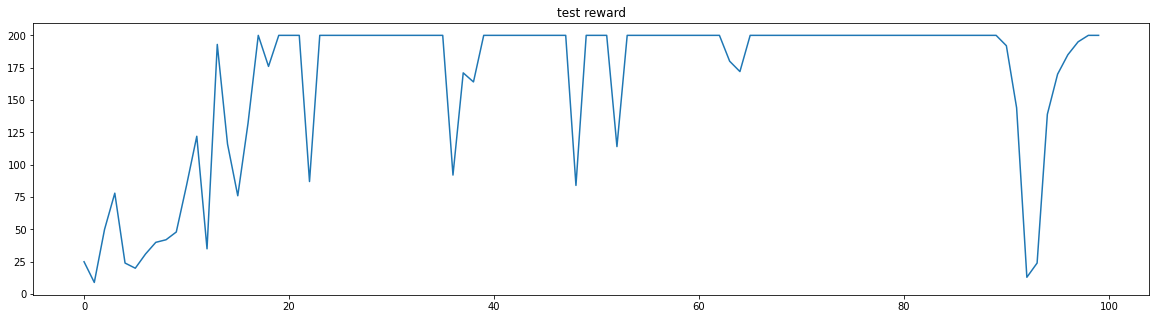

In [11]:
agents = [A3CAgent.remote("PongNoFrameskip-v4", i, device) for i in range(num_workers)]

pi_params = global_pi.get_weights()
v_params = global_v.get_weights()

gradient_list = [agent.compute_gradient.remote(pi_params, v_params) for agent in agents]

for step_i in range(1000):

    done_id, gradient_list = ray.wait(gradient_list)
    pi_grad, v_grad, id = ray.get(done_id)[0]
    
    global_pi_optimizer.zero_grad()
    global_v_optimizer.zero_grad()

    # set global pi & v gradient
    global_pi.set_grad(pi_grad)
    global_v.set_grad(v_grad)

    # step
    global_pi_optimizer.step()
    global_v_optimizer.step()

    gradient_list.append(agents[id].compute_gradient.remote(global_pi.get_weights(), global_v.get_weights()))

    if step_i % 10 == 0:
        test_reward = test(global_pi, env)
        rewards.append(test_reward)
        plot(rewards)
